Raw Data:
   Unnamed: 0     contributors  freeCodeCamp  free-programming-books  awesome  \
0           0        camperbot        1536.0                     NaN      NaN   
1           1      raisedadead        1487.0                     NaN      NaN   
2           2  ojeytonwilliams        1303.0                     NaN      NaN   
3           3    renovate[bot]        1262.0                     NaN      NaN   
4           4            sahat        1261.0                     NaN      NaN   

   build-your-own-x  public-apis  coding-interview-university  \
0               NaN          NaN                          NaN   
1               NaN          NaN                          NaN   
2               NaN          NaN                          NaN   
3               NaN          NaN                          NaN   
4               NaN          NaN                          NaN   

   developer-roadmap  system-design-primer  ...  django  app-ideas  bitcoin  \
0                NaN             

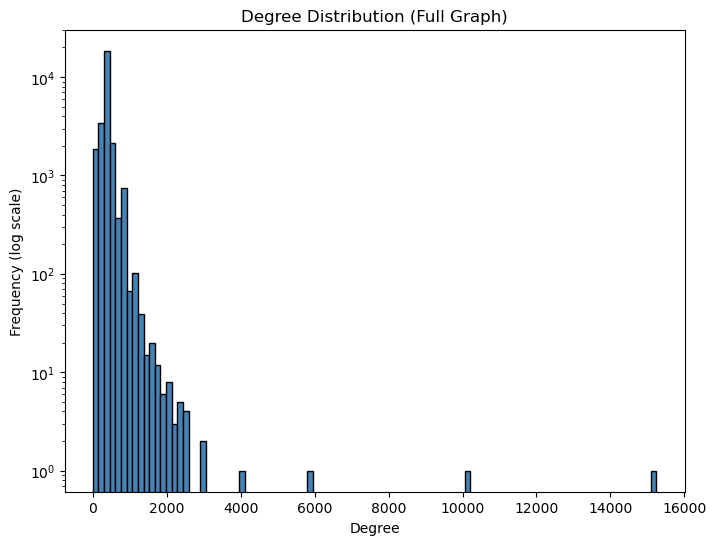


Top 5 nodes by Degree Centrality (Full Graph):
  dependabot[bot]: 0.5573
  eltociear: 0.3720
  github-actions[bot]: 0.2160
  jsoref: 0.1482
  spekulatius: 0.1095
Approximate Betweenness Centrality computation failed: module 'networkx.algorithms.approximation' has no attribute 'betweenness_centrality'


KeyboardInterrupt: 

In [7]:
# DSC291_Final_Project_v3.ipynb
# -------------------------------------------------------------
# This notebook loads your CSV data, preprocesses it, constructs
# a bipartite graph, and then projects it to a contributor network.
# We then apply some optimizations to handle large graphs:
#  - approximate betweenness centrality instead of exact
#  - optional filtering (degree or shared repo threshold)
#  - separate subgraph for final visualization
# -------------------------------------------------------------

import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import copy, random

# (Optional) If you need approximate betweenness from NetworkX:
# from networkx.algorithms import approximation as nx_approx

#####################
# 1. DATA LOADING  #
#####################
csv_file = "top_100_stars_nodes_df.csv"
df_raw = pd.read_csv(csv_file)
print("Raw Data:")
print(df_raw.head())

# We assume the CSV is in wide format with a 'contributors' column.
# If 'Unnamed: 0' is present, we drop it. Then we fill NaNs with 0.
if 'contributors' in df_raw.columns:
    df_clean = df_raw.set_index('contributors')
    if 'Unnamed: 0' in df_clean.columns:
        df_clean.drop(columns=['Unnamed: 0'], inplace=True)
    df_clean = df_clean.fillna(0)
    print("Data assumed to be in pivoted wide format.")
else:
    # If your CSV was in long format, pivot it:
    df_clean = df_raw.pivot_table(index='contributor',
                                  columns='repo',
                                  values='contributions',
                                  fill_value=0)
    print("Pivoted data (long -> wide).")

print(df_clean.head())

# If the index isn't unique, group duplicates (sum contributions).
if not df_clean.index.is_unique:
    df_clean = df_clean.groupby(df_clean.index).sum()

print("Is the index unique now?", df_clean.index.is_unique)
print(df_clean.head())

##########################
# 2. BIPARTITE BUILDING  #
##########################
B = nx.Graph()

# Extract contributors & repos
contributors = list(df_clean.index)
repos = list(df_clean.columns)

# Add nodes to the bipartite graph
B.add_nodes_from(contributors, bipartite='contributors')
B.add_nodes_from(repos, bipartite='repos')

# Here, we build edges only if there's at least 1 contribution
# If you want to reduce edges further, you can raise this threshold.
EDGE_THRESHOLD = 1  # only add edges if contributions >= 1

for contributor in contributors:
    for repo in repos:
        contrib_count = float(df_clean.at[contributor, repo])
        if contrib_count >= EDGE_THRESHOLD:
            B.add_edge(contributor, repo, weight=contrib_count)

print("Bipartite graph created:")
print(f"  #Contributor nodes: {len(contributors)}")
print(f"  #Repo nodes: {len(repos)}")
print(f"  #Edges in bipartite graph: {B.number_of_edges()}")

# Project bipartite -> contributor network
G = bipartite.weighted_projected_graph(B, contributors)
print("Contributor collaboration network:")
print(f"  Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

############################
# 3. OPTIONAL SUBGRAPHING  #
############################
# Large networks can be hard to compute or visualize.
# You can skip this if you want to do analysis on the full graph,
# but for visualization or advanced computations, it's wise to reduce size.

# Example: Filter out low-degree nodes
# (Keep nodes with degree >= 10, adjust as needed).
DEGREE_FILTER = 463
filtered_nodes = [n for n, deg in G.degree() if deg >= DEGREE_FILTER]
G_filtered = G.subgraph(filtered_nodes).copy()
print(f"Filtered subgraph with degree >= {DEGREE_FILTER}:")
print(f"  Nodes: {G_filtered.number_of_nodes()}, Edges: {G_filtered.number_of_edges()}")

##################################
# 4. CENTRALITY & COMMUNITY (FULL)
##################################
# If you still want centralities on the full graph, do them carefully.
# EXACT betweenness on a 5+ million-edge network is extremely slow.
# Consider approximate betweenness or do it on the filtered subgraph.

# For demonstration, let's do degree, closeness, and eigenvector on the filtered subgraph.
# (The full graph might be too large for some algorithms.)

deg_centrality_filt = nx.degree_centrality(G_filtered)
closeness_centrality_filt = nx.closeness_centrality(G_filtered)
# eigenvector can still be expensive, but let's try:
eigenvector_centrality_filt = nx.eigenvector_centrality(G_filtered, max_iter=1000)

# Approximate betweenness if needed:
# betw_centrality_filt = nx_approx.betweenness_centrality(G_filtered, k=500, normalized=True)
# (k=500 is a random subset of nodes for approximation; you can tune that.)

# Store them as attributes in the filtered graph
for node in G_filtered.nodes():
    G_filtered.nodes[node]['deg_cent'] = deg_centrality_filt[node]
    G_filtered.nodes[node]['clos_cent'] = closeness_centrality_filt[node]
    G_filtered.nodes[node]['eig_cent'] = eigenvector_centrality_filt[node]
    # G_filtered.nodes[node]['betw_cent'] = betw_centrality_filt[node]  # if used

# Example: print top 5 by degree in the filtered graph
top_deg = sorted(deg_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 (filtered) by degree centrality:")
for nd, sc in top_deg:
    print(f"  {nd}: {sc:.4f}")

##############################
# 5. COMMUNITY DETECTION (FILTERED)
##############################
import community as community_louvain

partition_filt = community_louvain.best_partition(G_filtered)
for node, comm in partition_filt.items():
    G_filtered.nodes[node]['community'] = comm

num_coms_filt = len(set(partition_filt.values()))
print(f"Detected {num_coms_filt} communities in the filtered subgraph.")

###########################################
# 6. ROBUSTNESS SIMULATION (FILTERED ONLY)
###########################################
def largest_component_size(graph):
    if graph.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(graph), key=len))

G_targeted = copy.deepcopy(G_filtered)
G_random = copy.deepcopy(G_filtered)

targeted_nodes = sorted(G_targeted.degree(), key=lambda x: x[1], reverse=True)
component_sizes_targeted = []

print("Starting targeted removal simulation (filtered subgraph):")
for i, (node, _) in enumerate(targeted_nodes):
    G_targeted.remove_node(node)
    if (i + 1) % 50 == 0:  # smaller step for demonstration
        size = largest_component_size(G_targeted)
        component_sizes_targeted.append(size)
        print(f"  Removed {i+1} nodes, largest comp size: {size}")

nodes_random = list(G_random.nodes())
random.shuffle(nodes_random)
component_sizes_random = []

print("Starting random removal simulation (filtered subgraph):")
for i, node in enumerate(nodes_random):
    G_random.remove_node(node)
    if (i + 1) % 50 == 0:
        size = largest_component_size(G_random)
        component_sizes_random.append(size)
        print(f"  Removed {i+1} nodes, largest comp size: {size}")

######################################
# 7. EXPORT FOR VISUALIZATION
######################################
# We'll export the filtered subgraph (much smaller) to GEXF for Gephi
# and also do a Pyvis visualization on the filtered subgraph.
# This should be feasible, as G_filtered is smaller than G.

nx.write_gexf(G_filtered, "github_collaboration_filtered.gexf")
print("Filtered subgraph exported to github_collaboration_filtered.gexf")


############################
# END OF NOTEBOOK
############################

# Summary of optimizations:
# - We do an 'EDGE_THRESHOLD' for bipartite edges (avoid edges with <1 contribution).
# - We do a 'DEGREE_FILTER' to remove low-degree nodes from the final subgraph.
# - We use approximate or partial centrality measures on the filtered subgraph
#   instead of the full graph, which is huge.
# - We run robustness simulations and Pyvis on the filtered subgraph to avoid
#   memory/time issues.
#
# Adjust the thresholds to find a balance between capturing enough structure
# and having a manageable network size.


After edge-weight filtering (>= 2):
  Nodes: 3104 Edges: 33735
Largest connected component size:
  Nodes: 1513 Edges: 33649
Top 500 subgraph by degree:
  Nodes: 500 Edges: 29824
github_collaboration_filtered.html
Pyvis visualization saved as github_collaboration_filtered.html


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Compute degrees for all nodes in the full graph
degrees = np.array([d for n, d in G.degree()])

# Print basic statistics
print("Degree Statistics:")
print("  Min:", degrees.min())
print("  Max:", degrees.max())
print("  Mean:", degrees.mean())
print("  Median:", np.median(degrees))

# Plot the degree distribution histogram
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, color="skyblue", edgecolor="black")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale("log")  # log scale helps reveal the tail behavior
plt.show()

# Determine a new threshold based on a percentile (e.g., 90th percentile)
threshold = np.percentile(degrees, 95)
print("90th percentile degree threshold:", threshold)

# Alternatively, if you want a fixed number of nodes (e.g., top 10%):
top_10_percent_threshold = np.percentile(degrees, 95)  # Top 10% will be above the 90th percentile
print("Using top 10% of nodes: degree >= {:.0f}".format(top_10_percent_threshold))

# Create a filtered subgraph using this new threshold:
filtered_nodes_new = [n for n, d in G.degree() if d >= top_10_percent_threshold]
G_filtered_new = G.subgraph(filtered_nodes_new).copy()
print("Filtered subgraph with degree >= 90th percentile:")
print("  Nodes:", G_filtered_new.number_of_nodes())
print("  Edges:", G_filtered_new.number_of_edges())


NameError: name 'G' is not defined